In [103]:
import numpy as np
import pandas as pd
import pypianoroll as pr
import matplotlib.pyplot as plt
import importlib
import json
import xml.etree.ElementTree as ET
import os
import sys
import pickle

In [164]:
data = pd.read_excel('C:\\Users\\Administrator\\Desktop\\华为云盘\\学习资料\\博士讨论班\\高频\\task\\2021.11.14/流通市值+涨跌停+停牌.xlsx',sheet_name=1)

In [169]:
data.head()

,代码,名称,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,...,2020-12-18 00:00:00,2020-12-21 00:00:00,2020-12-22 00:00:00,2020-12-23 00:00:00,2020-12-24 00:00:00,2020-12-25 00:00:00,2020-12-28 00:00:00,2020-12-29 00:00:00,2020-12-30 00:00:00,2020-12-31 00:00:00
0,000001.SZ,平安银行,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000002.SZ,万科A,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000004.SZ,国华网安,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000005.SZ,ST星源,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000006.SZ,深振业A,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
data[data['代码']=='000001.SZ'][datetime.datetime(2020,1,2)].values[0]

0

In [174]:
with open('F:\\Documents\\学习资料\\博士工作\\流动性/000016.pkl','rb') as f:
    a = pickle.load(f)
a

{'bid': [],
 'ask': [],
 'mid': [],
 'mean_price': [],
 'volume': [],
 'qty': [],
 'OrderCount': array([0., 0., 0., ..., 0., 0., 0.]),
 'OrderQty': array([0., 0., 0., ..., 0., 0., 0.]),
 'OrderVol': array([0., 0., 0., ..., 0., 0., 0.]),
 'TradeCount': array([0., 0., 0., ..., 0., 0., 0.]),
 'TradeQty': array([0., 0., 0., ..., 0., 0., 0.]),
 'TradeVol': array([0., 0., 0., ..., 0., 0., 0.]),
 'lifetime_ExecQty_wavg': [],
 'spread': array([0., 0., 0., ..., 0., 0., 0.]),
 'relative_spread': array([0., 0., 0., ..., 0., 0., 0.]),
 'wavg_spread_5': array([0., 0., 0., ..., 0., 0., 0.]),
 'relative_wavg_spread_5': array([0., 0., 0., ..., 0., 0., 0.]),
 'wavg_spread_10': array([0., 0., 0., ..., 0., 0., 0.]),
 'relative_wavg_spread_10': array([0., 0., 0., ..., 0., 0., 0.]),
 'wavg_spread_20': array([0., 0., 0., ..., 0., 0., 0.]),
 'relative_wavg_spread_20': array([0., 0., 0., ..., 0., 0., 0.]),
 'wavg_spread_30': array([0., 0., 0., ..., 0., 0., 0.]),
 'relative_wavg_spread_30': array([0., 0., 0., 

In [175]:
data = pd.read_csv('F:\\Documents\\学习资料\\博士工作\\流动性/snapshot.csv')
data

,orig_time,BidSize1,BidSize2,BidSize3,BidSize4,BidSize5,BidSize6,BidSize7,BidSize8,BidSize9,...,wavg_spread_400,relative_wavg_spread_400,wavg_spread_500,relative_wavg_spread_500,OrderCount,OrderQty,OrderVol,TradeCount,TradeQty,TradeVol
0,2020-01-02 09:30:03,500.0,1600.0,5000.0,3600.0,500.0,1900.0,15200.0,7100.0,30100.0,...,0.198964,0.012165,0.198964,0.012165,50,65620,1091768.6,18,9300,151892.0
1,2020-01-02 09:30:06,1000.0,2300.0,500.0,4700.0,15200.0,7100.0,24400.0,1500.0,2300.0,...,0.219989,0.013455,0.219989,0.013455,15,25700,423271.0,12,11700,191121.0
2,2020-01-02 09:30:09,600.0,1000.0,200.0,2300.0,500.0,10700.0,15200.0,7100.0,24400.0,...,0.226032,0.013808,0.226032,0.013808,13,43860,763069.0,1,300,4908.0
3,2020-01-02 09:30:12,1000.0,1900.0,6000.0,200.0,2300.0,500.0,10700.0,15200.0,1300.0,...,0.212810,0.012988,0.212810,0.012988,7,10900,178664.0,3,2300,37674.0
4,2020-01-02 09:30:18,1900.0,6000.0,200.0,2300.0,500.0,10700.0,15200.0,1600.0,7100.0,...,0.234362,0.014312,0.234362,0.014312,3,2200,36398.0,2,1400,22936.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,2020-01-02 14:56:48,2500.0,2700.0,3400.0,1100.0,4700.0,200.0,200.0,1400.0,1500.0,...,0.067668,0.003986,0.067668,0.003986,3,20700,351686.0,1,200,3396.0
2600,2020-01-02 14:56:51,2500.0,2700.0,2800.0,1100.0,4700.0,200.0,200.0,1400.0,1500.0,...,0.067982,0.004005,0.067982,0.004005,2,2100,35645.0,0,0,0.0
2601,2020-01-02 14:56:54,3800.0,2700.0,2800.0,1100.0,4700.0,200.0,200.0,1400.0,1500.0,...,0.065639,0.003867,0.065639,0.003867,3,1100,18678.0,3,700,11886.0
2602,2020-01-02 14:56:57,4200.0,2700.0,2800.0,1100.0,4700.0,200.0,200.0,1400.0,1500.0,...,0.064990,0.003829,0.064990,0.003829,4,7000,118846.0,4,2300,39049.0


In [139]:
index = [datetime.datetime(2020, 1, 1, 9, 30, 3) + datetime.timedelta(seconds=3 * i) for i in range(2400)]
index += [datetime.datetime(2020, 1, 1, 13, 0, 0) + datetime.timedelta(seconds=3 * i) for i in range(1, 2341)]
len(index)

4740

In [84]:
g = {}
g[1] = [2,3]
g[2] = [1,3,4]
g[3] = [1,2,4,5]
g[4] = [2,3,5,6]
g[5] = [3,4]
g[6] = [4]
w = {}
w[(1,2)] = 5
w[(1,3)] = 1
w[(2,3)] = 2
w[(2,4)] = 1
w[(3,4)] = 4
w[(3,5)] = 8
w[(4,5)] = 3
w[(4,6)] = 6
kk = list(w.keys())
for k in kk:
    w[(k[1],k[0])] = w[k]
heap_dijkstra(g,w,1,6)

done with 0.0000s


10.0

In [2]:
sys.path.append('..')
import dataloader
importlib.reload(dataloader)
from dataloader import DataLoader
importlib.reload(DataLoader)
DL = DataLoader.DataLoader()
# DL.process_raw_data()

In [20]:
pd.DataFrame(np.array([np.array([1,2]),np.array([1,2])]).T)

,0,1
0,1,1
1,2,2


In [7]:
DL.train_data[0]['chord'].shape

(8, 128)

In [11]:
a = DL.train_data[1]['chord']

In [12]:
a[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 100,   0,   0, 100,   0,   0,   0,
       100,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

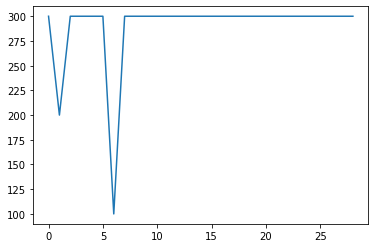

In [13]:
plt.plot(np.sum(a,axis=1))

In [15]:
a['pianoroll_0_csc_shape']

array([768, 128], dtype=int64)

In [33]:
multitrack = pr.read("F:\\Documents\\学习资料\\自动配和弦\\datasets\\pianoroll\\a\\above-and-beyond\\always/chorus_key.mid")
print(multitrack)

Multitrack(name=None, resolution=24, tempo=array(shape=(888, 1), dtype=float64), downbeat=array(shape=(888, 1), dtype=bool), tracks=[StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8)), StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8))])


In [40]:
multitrack = pr.read("F:\\Documents\\学习资料\\自动配和弦\\datasets\\pianoroll\\a\\above-and-beyond\\always/chorus_nokey.mid")
print(multitrack)

Multitrack(name=None, resolution=24, tempo=array(shape=(888, 1), dtype=float64), downbeat=array(shape=(888, 1), dtype=bool), tracks=[StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8)), StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(888, 128), dtype=uint8))])


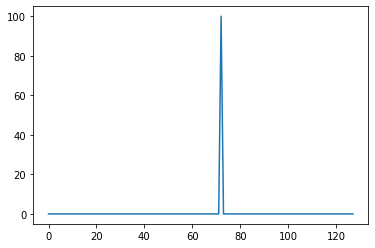

In [39]:
plt.plot(multitrack.tracks[0].pianoroll[97])